In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import cv2
import numpy as np
import torch
import torchvision
from typing import Callable, List, Tuple
import tqdm
from collections import OrderedDict


In [2]:
class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))
            # Because of https://github.com/pytorch/pytorch/issues/61519,
            # we don't use backward hook to record gradients.
            self.handles.append(
                target_layer.register_forward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output
        
        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return

        # Gradients are computed in reverse order
        def _store_grad(grad):
            if self.reshape_transform is not None:
                grad = self.reshape_transform(grad)
            self.gradients = [grad.cpu().detach()] + self.gradients

        output.register_hook(_store_grad)

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()

In [3]:
def scale_cam_image(cam, target_size=None):
    result = []
    for img in cam:
        img = img - np.min(img)
        img = img / (1e-7 + np.max(img))
        if target_size is not None:
            img = cv2.resize(img, target_size)
        result.append(img)
    result = np.float32(result)

    return result

In [4]:
def get_2d_projection(activation_batch):
    # TBD: use pytorch batch svd implementation
    activation_batch[np.isnan(activation_batch)] = 0
    projections = []
    for activations in activation_batch:
        reshaped_activations = (activations).reshape(
            activations.shape[0], -1).transpose()
        # Centering before the SVD seems to be important here,
        # Otherwise the image returned is negative
        reshaped_activations = reshaped_activations - \
            reshaped_activations.mean(axis=0)
        U, S, VT = np.linalg.svd(reshaped_activations, full_matrices=True)
        projection = reshaped_activations @ VT[0, :]
        projection = projection.reshape(activations.shape[1:])
        projections.append(projection)
    return np.float32(projections)

In [5]:
class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category
    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]

In [6]:
class BaseCAM:
    def __init__(self,
                 model: torch.nn.Module,
                 target_layers: List[torch.nn.Module],
                 use_cuda: bool = False,
                 reshape_transform: Callable = None,
                 compute_input_gradient: bool = False,
                 uses_gradients: bool = True) -> None:
        self.model = model.eval()
        self.target_layers = target_layers
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        self.activations_and_grads = ActivationsAndGradients(
            self.model, target_layers, reshape_transform)

    """ Get a vector of weights for every channel in the target layer.
        Methods that return weights channels,
        will typically need to only implement this function. """

    def get_cam_weights(self,
                        input_tensor: torch.Tensor,
                        target_layers: List[torch.nn.Module],
                        targets: List[torch.nn.Module],
                        activations: torch.Tensor,
                        grads: torch.Tensor) -> np.ndarray:
        raise Exception("Not Implemented")

    def get_cam_image(self,
                      input_tensor: torch.Tensor,
                      target_layer: torch.nn.Module,
                      targets: List[torch.nn.Module],
                      activations: torch.Tensor,
                      grads: torch.Tensor,
                      eigen_smooth: bool = False) -> np.ndarray:

        weights = self.get_cam_weights(input_tensor,
                                       target_layer,
                                       targets,
                                       activations,
                                       grads)
        weighted_activations = weights[:, :, None, None] * activations
        if eigen_smooth:
            cam = get_2d_projection(weighted_activations)
        else:
            cam = weighted_activations.sum(axis=1)
        return cam

    def forward(self,
                input_tensor: torch.Tensor,
                targets: List[torch.nn.Module],
                eigen_smooth: bool = False) -> np.ndarray:

        if self.cuda:
            input_tensor = input_tensor.cuda()

        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor,
                                                   requires_grad=True)

        outputs = self.activations_and_grads(input_tensor)
        if targets is None:
            target_categories = np.argmax(outputs.cpu().data.numpy(), axis=-1)
            targets = [ClassifierOutputTarget(category) for category in target_categories]

        if self.uses_gradients:
            self.model.zero_grad()
            loss = sum([target(output) for target, output in zip(targets, outputs)])
            loss.backward(retain_graph=True)

        # In most of the saliency attribution papers, the saliency is
        # computed with a single target layer.
        # Commonly it is the last convolutional layer.
        # Here we support passing a list with multiple target layers.
        # It will compute the saliency image for every image,
        # and then aggregate them (with a default mean aggregation).
        # This gives you more flexibility in case you just want to
        # use all conv layers for example, all Batchnorm layers,
        # or something else.
        cam_per_layer = self.compute_cam_per_layer(input_tensor,
                                                   targets,
                                                   eigen_smooth)
        return self.aggregate_multi_layers(cam_per_layer)

    def get_target_width_height(self,
                                input_tensor: torch.Tensor) -> Tuple[int, int]:
        width, height = input_tensor.size(-1), input_tensor.size(-2)
        return width, height

    def compute_cam_per_layer(
            self,
            input_tensor: torch.Tensor,
            targets: List[torch.nn.Module],
            eigen_smooth: bool) -> np.ndarray:
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads.gradients]
        target_size = self.get_target_width_height(input_tensor)

        cam_per_target_layer = []
        # Loop over the saliency image from every layer
        for i in range(len(self.target_layers)):
            target_layer = self.target_layers[i]
            layer_activations = None
            layer_grads = None
            if i < len(activations_list):
                layer_activations = activations_list[i]
            if i < len(grads_list):
                layer_grads = grads_list[i]

            cam = self.get_cam_image(input_tensor,
                                     target_layer,
                                     targets,
                                     layer_activations,
                                     layer_grads,
                                     eigen_smooth)
            cam = np.maximum(cam, 0)
            scaled = scale_cam_image(cam, target_size)
            cam_per_target_layer.append(scaled[:, None, :])

        return cam_per_target_layer

    def aggregate_multi_layers(self, cam_per_target_layer: np.ndarray) -> np.ndarray:
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        result = np.mean(cam_per_target_layer, axis=1)
        return scale_cam_image(result)

    def forward_augmentation_smoothing(self,
                                       input_tensor: torch.Tensor,
                                       targets: List[torch.nn.Module],
                                       eigen_smooth: bool = False) -> np.ndarray:
        transforms = tta.Compose(
            [
                tta.HorizontalFlip(),
                tta.Multiply(factors=[0.9, 1, 1.1]),
            ]
        )
        cams = []
        for transform in transforms:
            augmented_tensor = transform.augment_image(input_tensor)
            cam = self.forward(augmented_tensor,
                               targets,
                               eigen_smooth)

            # The ttach library expects a tensor of size BxCxHxW
            cam = cam[:, None, :, :]
            cam = torch.from_numpy(cam)
            cam = transform.deaugment_mask(cam)

            # Back to numpy float32, HxW
            cam = cam.numpy()
            cam = cam[:, 0, :, :]
            cams.append(cam)

        cam = np.mean(np.float32(cams), axis=0)
        return cam

    def __call__(self,
                 input_tensor: torch.Tensor,
                 targets: List[torch.nn.Module] = None,
                 aug_smooth: bool = False,
                 eigen_smooth: bool = False) -> np.ndarray:

        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            return self.forward_augmentation_smoothing(
                input_tensor, targets, eigen_smooth)

        return self.forward(input_tensor,
                            targets, eigen_smooth)

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True


In [7]:
class EigenCAM(BaseCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(EigenCAM, self).__init__(model, target_layers, use_cuda,
                                       reshape_transform)

    def get_cam_image(self,
                      input_tensor,
                      target_layer,
                      target_category,
                      activations,
                      grads,
                      eigen_smooth):
        return get_2d_projection(activations)

In [8]:
def replace_layer_recursive(model, old_layer, new_layer):
    for name, layer in model._modules.items():
        if layer == old_layer:
            model._modules[name] = new_layer
            return True
        elif replace_layer_recursive(layer, old_layer, new_layer):
            return True
    return False

In [10]:
class AblationLayer(torch.nn.Module):
    def __init__(self):
        super(AblationLayer, self).__init__()

    def objectiveness_mask_from_svd(self, activations, threshold=0.01):
        """ Experimental method to get a binary mask to compare if the activation is worth ablating.
            The idea is to apply the EigenCAM method by doing PCA on the activations.
            Then we create a binary mask by comparing to a low threshold.
            Areas that are masked out, are probably not interesting anyway.
        """

        projection = get_2d_projection(activations[None, :])[0, :]
        projection = np.abs(projection)
        projection = projection - projection.min()
        projection = projection / projection.max()
        projection = projection > threshold
        return projection

    def activations_to_be_ablated(self, activations, ratio_channels_to_ablate=1.0):
        """ Experimental method to get a binary mask to compare if the activation is worth ablating.
            Create a binary CAM mask with objectiveness_mask_from_svd.
            Score each Activation channel, by seeing how much of its values are inside the mask.
            Then keep the top channels.
        """
        if ratio_channels_to_ablate == 1.0:
            self.indices = np.int32(range(activations.shape[0]))
            return self.indices

        projection = self.objectiveness_mask_from_svd(activations)

        scores = []
        for channel in activations:
            normalized = np.abs(channel)
            normalized = normalized - normalized.min()
            normalized = normalized / np.max(normalized)
            score = (projection*normalized).sum() / normalized.sum()
            scores.append(score)
        scores = np.float32(scores)

        indices = list(np.argsort(scores))
        high_score_indices = indices[::-1][: int(len(indices) * ratio_channels_to_ablate)]
        low_score_indices = indices[: int(len(indices) * ratio_channels_to_ablate)]
        self.indices = np.int32(high_score_indices + low_score_indices)
        return self.indices

    def set_next_batch(self, input_batch_index, activations, num_channels_to_ablate):
        """ This creates the next batch of activations from the layer.
            Just take corresponding batch member from activations, and repeat it num_channels_to_ablate times.
        """
        self.activations = activations[input_batch_index, :, :, :].clone().unsqueeze(0).repeat(num_channels_to_ablate, 1, 1, 1)

    def __call__(self, x):
        output = self.activations
        for i in range(output.size(0)):
            # Commonly the minimum activation will be 0,
            # And then it makes sense to zero it out.
            # However depending on the architecture,
            # If the values can be negative, we use very negative values
            # to perform the ablation, deviating from the paper.
            if torch.min(output) == 0:
                output[i, self.indices[i], :] = 0
            else:
                ABLATION_VALUE = 1e7
                output[i, self.indices[i], :] = torch.min(
                    output) - ABLATION_VALUE

        return output


class AblationLayerVit(AblationLayer):
    def __init__(self):
        super(AblationLayerVit, self).__init__()

    def __call__(self, x):
        output = self.activations
        output = output.transpose(1, 2)
        for i in range(output.size(0)):

            # Commonly the minimum activation will be 0,
            # And then it makes sense to zero it out.
            # However depending on the architecture,
            # If the values can be negative, we use very negative values
            # to perform the ablation, deviating from the paper.
            if torch.min(output) == 0:
                output[i, self.indices[i], :] = 0
            else:
                ABLATION_VALUE = 1e7
                output[i, self.indices[i], :] = torch.min(
                    output) - ABLATION_VALUE

        output = output.transpose(2, 1)

        return output


class AblationLayerFasterRCNN(AblationLayer):
    def __init__(self):
        super(AblationLayerFasterRCNN, self).__init__()

    def set_next_batch(self, input_batch_index, activations, num_channels_to_ablate):
        """ Extract the next batch member from activations,
            and repeat it num_channels_to_ablate times.
        """
        self.activations = OrderedDict()
        for key, value in activations.items():
            fpn_activation = value[input_batch_index, :, :, :].clone().unsqueeze(0)
            self.activations[key] = fpn_activation.repeat(num_channels_to_ablate, 1, 1, 1)

    def __call__(self, x):
        result = self.activations
        layers = {0: '0', 1: '1', 2: '2', 3: '3', 4: 'pool'}
        num_channels_to_ablate = result['pool'].size(0)
        for i in range(num_channels_to_ablate):
            pyramid_layer = int(self.indices[i]/256)
            index_in_pyramid_layer = int(self.indices[i] % 256)
            result[layers[pyramid_layer]][i, index_in_pyramid_layer, :, :] = -1000
        return result

In [11]:
class AblationCAM(BaseCAM):
    def __init__(self,
                 model: torch.nn.Module,
                 target_layers: List[torch.nn.Module],
                 use_cuda: bool = False,
                 reshape_transform: Callable = None,
                 ablation_layer: torch.nn.Module = AblationLayer(),
                 batch_size: int = 32,
                 ratio_channels_to_ablate: float = 1.0) -> None:

        super(AblationCAM, self).__init__(model,
                                          target_layers,
                                          use_cuda,
                                          reshape_transform,
                                          uses_gradients=False)
        self.batch_size = batch_size
        self.ablation_layer = ablation_layer
        self.ratio_channels_to_ablate = ratio_channels_to_ablate

    def save_activation(self, module, input, output) -> None:
        """ Helper function to save the raw activations from the target layer """
        self.activations = output

    def assemble_ablation_scores(self,
                                 new_scores: list,
                                 original_score: float ,
                                 ablated_channels: np.ndarray,
                                 number_of_channels: int) -> np.ndarray:
        """ Take the value from the channels that were ablated,
            and just set the original score for the channels that were skipped """

        index = 0
        result = []
        sorted_indices = np.argsort(ablated_channels)
        ablated_channels = ablated_channels[sorted_indices]
        new_scores = np.float32(new_scores)[sorted_indices]

        for i in range(number_of_channels):
            if index < len(ablated_channels) and ablated_channels[index] == i:
                weight = new_scores[index]
                index = index + 1
            else:
                weight = original_score
            result.append(weight)

        return result

    def get_cam_weights(self,
                        input_tensor: torch.Tensor,
                        target_layer: torch.nn.Module,
                        targets: List[Callable],
                        activations: torch.Tensor,
                        grads: torch.Tensor) -> np.ndarray:
        
        # Do a forward pass, compute the target scores, and cache the activations
        handle = target_layer.register_forward_hook(self.save_activation)
        with torch.no_grad():
            outputs = self.model(input_tensor)
            handle.remove()
            original_scores = np.float32([target(output).cpu().item() for target, output in zip(targets, outputs)])

        # Replace the layer with the ablation layer.
        # When we finish, we will replace it back, so the original model is unchanged.
        ablation_layer = self.ablation_layer
        replace_layer_recursive(self.model, target_layer, ablation_layer)

        number_of_channels = activations.shape[1]
        weights = []
        # This is a "gradient free" method, so we don't need gradients here.
        with torch.no_grad():
            # Loop over each of the batch images and ablate activations for it.
            for batch_index, (target, tensor) in enumerate(zip(targets, input_tensor)):
                new_scores = []
                batch_tensor = tensor.repeat(self.batch_size, 1, 1, 1)

                # Check which channels should be ablated. Normally this will be all channels,
                # But we can also try to speed this up by using a low ratio_channels_to_ablate.
                channels_to_ablate = ablation_layer.activations_to_be_ablated(activations[batch_index, :],
                                                                              self.ratio_channels_to_ablate)
                number_channels_to_ablate = len(channels_to_ablate)

                for i in tqdm.tqdm(range(0, number_channels_to_ablate, self.batch_size)):
                    if i + self.batch_size > number_channels_to_ablate:
                        batch_tensor = batch_tensor[:(number_channels_to_ablate - i)]

                    # Change the state of the ablation layer so it ablates the next channels.
                    # TBD: Move this into the ablation layer forward pass.
                    ablation_layer.set_next_batch(input_batch_index=batch_index,
                                                  activations=self.activations,
                                                  num_channels_to_ablate=batch_tensor.size(0))
                    score = [target(o).cpu().item() for o in self.model(batch_tensor)]
                    new_scores.extend(score)
                    ablation_layer.indices = ablation_layer.indices[batch_tensor.size(0):]

                new_scores = self.assemble_ablation_scores(new_scores,
                                                           original_scores[batch_index],
                                                           channels_to_ablate,
                                                           number_of_channels)
                weights.extend(new_scores)

        weights = np.float32(weights)
        weights = weights.reshape(activations.shape[:2])
        original_scores = original_scores[:, None]
        weights = (original_scores - weights) / original_scores

        # Replace the model back to the original state
        replace_layer_recursive(self.model, ablation_layer, target_layer)
        return weights

In [12]:
class FasterRCNNBoxScoreTarget:
    """ For every original detected bounding box specified in "bounding boxes",
        assign a score on how the current bounding boxes match it,
            1. In IOU
            2. In the classification score.
        If there is not a large enough overlap, or the category changed,
        assign a score of 0.
        The total score is the sum of all the box scores.
    """

    def __init__(self, labels, bounding_boxes, iou_threshold=0.5):
        self.labels = labels
        self.bounding_boxes = bounding_boxes
        self.iou_threshold = iou_threshold

    def __call__(self, model_outputs):
        output = torch.Tensor([0])
        if torch.cuda.is_available():
            output = output.cuda()

        if len(model_outputs["boxes"]) == 0:
            return output

        for box, label in zip(self.bounding_boxes, self.labels):
            box = torch.Tensor(box[None, :])
            if torch.cuda.is_available():
                box = box.cuda()

            ious = torchvision.ops.box_iou(box, model_outputs["boxes"])
            index = ious.argmax()
            if ious[0, index] > self.iou_threshold and model_outputs["labels"][index] == label:
                score = ious[0, index] + model_outputs["scores"][index]
                output = output + score
        return output

In [13]:
def fasterrcnn_reshape_transform(x):
    target_size = x['pool'].size()[-2 : ]
    activations = []
    for key, value in x.items():
        activations.append(torch.nn.functional.interpolate(torch.abs(value), target_size, mode='bilinear'))
    activations = torch.cat(activations, axis=1)
    return activations

In [14]:
def preprocess_image(img: np.ndarray, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) -> torch.Tensor:
    preprocessing = Compose([
        ToTensor(),
        Normalize(mean=mean, std=std)
    ])
    return preprocessing(img.copy()).unsqueeze(0)

In [15]:
def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.
    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :returns: The default image with the cam overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    cam = heatmap + img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

def scale_accross_batch_and_channels(tensor, target_size):
    batch_size, channel_size = tensor.shape[:2]
    reshaped_tensor = tensor.reshape(
        batch_size * channel_size, *tensor.shape[2:])
    result = scale_cam_image(reshaped_tensor, target_size)
    result = result.reshape(
        batch_size,
        channel_size,
        target_size[1],
        target_size[0])
    return result


In [16]:
def predict(input_tensor, model, device, detection_threshold):
    outputs = model(input_tensor)
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    
    boxes, classes, labels, indices = [], [], [], []
    for index in range(len(pred_scores)):
        if pred_scores[index] >= detection_threshold:
            boxes.append(pred_bboxes[index].astype(np.int32))
            classes.append(pred_classes[index])
            labels.append(pred_labels[index])
            indices.append(index)
    boxes = np.int32(boxes)
    return boxes, classes, labels, indices

def draw_boxes(boxes, labels, classes, image):
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1] - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return image

coco_names = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', \
              'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 
              'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 
              'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella',
              'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
              'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
              'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork',
              'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
              'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
              'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet',
              'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
              'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase',
              'scissors', 'teddy bear', 'hair drier', 'toothbrush']


# This will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

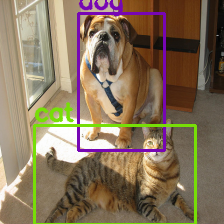

In [17]:
import requests
import torchvision
from PIL import Image
image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
image = np.array(Image.open(requests.get(image_url, stream=True).raw))
image_float_np = np.float32(image) / 255
# define the torchvision image transforms
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

input_tensor = transform(image)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
# Add a batch dimension:
input_tensor = input_tensor.unsqueeze(0)

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval().to(device)

# Run the model and display the detections
boxes, classes, labels, indices = predict(input_tensor, model, device, 0.9)
image = draw_boxes(boxes, labels, classes, image)

# Show the image:
Image.fromarray(image)

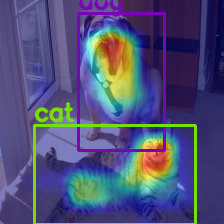

In [18]:
target_layers = [model.backbone]
targets = [FasterRCNNBoxScoreTarget(labels=labels, bounding_boxes=boxes)]
cam = EigenCAM(model,
               target_layers, 
               use_cuda=torch.cuda.is_available(),
               reshape_transform=fasterrcnn_reshape_transform)

grayscale_cam = cam(input_tensor, targets=targets)
# Take the first image in the batch:
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
# And lets draw the boxes again:
image_with_bounding_boxes = draw_boxes(boxes, labels, classes, cam_image)
Image.fromarray(image_with_bounding_boxes)

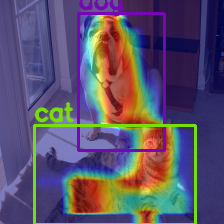

In [19]:
def renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    for x1, y1, x2, y2 in boxes:
        renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_boxes(boxes, labels, classes, eigencam_image_renormalized)
    return image_with_bounding_boxes

Image.fromarray(renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam))

100%|██████████| 40/40 [01:48<00:00,  2.70s/it]


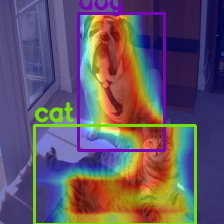

In [20]:
cam = AblationCAM(model,
               target_layers, 
               use_cuda=torch.cuda.is_available(), 
               reshape_transform=fasterrcnn_reshape_transform,
               ablation_layer=AblationLayerFasterRCNN())

grayscale_cam = cam(input_tensor, targets=targets)[0, :]
Image.fromarray(renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam))

100%|██████████| 8/8 [00:21<00:00,  2.71s/it]


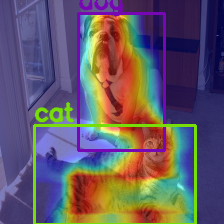

In [21]:
ratio_channels_to_ablate = 0.1
cam = AblationCAM(model,
               target_layers, 
               use_cuda=torch.cuda.is_available(), 
               reshape_transform=fasterrcnn_reshape_transform,
               ablation_layer=AblationLayerFasterRCNN(),
               ratio_channels_to_ablate=ratio_channels_to_ablate)

grayscale_cam = cam(input_tensor, targets=targets)[0, :]
Image.fromarray(renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam))

100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


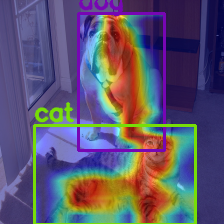

In [22]:
ratio_channels_to_ablate = 0.01
cam = AblationCAM(model,
               target_layers, 
               use_cuda=torch.cuda.is_available(), 
               reshape_transform=fasterrcnn_reshape_transform,
               ablation_layer=AblationLayerFasterRCNN(),
               ratio_channels_to_ablate=ratio_channels_to_ablate)

grayscale_cam = cam(input_tensor, targets=targets)[0, :]
Image.fromarray(renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam))